# Competition and Collaboration
## Udacity Deep Reinforcement Learning project 3

### Import Used Libraries

In [1]:
import torch
import numpy as np
import matplotlib as plt
from unityagents import UnityEnvironment

### Check for Graphics Card

In [2]:
# Check Cuda is available
if torch.cuda.is_available():
    # Get Device Count
    GPUCount = torch.cuda.device_count()
    
    # Print Device Names
    print("Devices Available:")
    for i in range(0, GPUCount):
        print(i,": ", torch.cuda.get_device_name(i))

    # Check Current Device and Print Explicit Message
    print("\nCurrent Device in use is Device #",
          torch.cuda.current_device(),": ",
          torch.cuda.get_device_name(torch.cuda.current_device()))
    
    device = torch.device("cuda:0")
    
else:
    device = torch.device("cpu")
    print("CUDA Not Available!\nWill Train on CPU")

Devices Available:
0 :  GeForce GTX 970

Current Device in use is Device # 0 :  GeForce GTX 970


### Load Tennis Environment

In [3]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe", no_graphics = False)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


### Get Environment Brain an examine environment

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


## Actor-Critic Neural Network Definitions
### Imports for Neural Network Definitions

In [5]:
import numpy as np

import torch.nn as nn
import torch.nn.functional as F

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

### Define Actor Neural Network

In [6]:
class Actor(nn.Module):
    """Actor (Policy) Model."""
    
    def __init__(self, state_size, action_size, seed, fc1_units = 256, fc2_units = 128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()
        
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))

### Define Critic Network

In [7]:
class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

## Agent Definition

### Imports


In [8]:
import random
from collections import namedtuple, deque
import torch.optim as optim
import copy

### Noise Function

In [9]:
class ActionNoise(object):
    def reset(self):
        pass

# Based on http://math.stackexchange.com/questions/1287634/implementing-ornstein-uhlenbeck-in-matlab
class OrnsteinUhlenbeckActionNoise(ActionNoise):
    def __init__(self, mu, sigma, theta=.15, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def sample(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(self.mu, self.sigma)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.size = size
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = dx
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        
        #print(self.state)
        return self.state

## Replay Buffer

In [10]:
class ReplayBuffer:
    def __init__(self, action_size, replay_buffer_size, batch_size, seed):
        self.batch_size = batch_size
        self.seed = random.seed(seed)
        self.action_size = action_size
        self.memory = deque(maxlen=replay_buffer_size)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def add(self, state, action, reward, next_state, done):
        exp = self.experience(state, action, reward, next_state, done)
        self.memory.append(exp)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([ex.state for ex in experiences if ex is not None])
                                 ).float().to(device)
        actions = torch.from_numpy(np.vstack([ex.action for ex in experiences if ex is not None])
                                  ).float().to(device)
        rewards = torch.from_numpy(np.vstack([ex.reward for ex in experiences if ex is not None])
                                  ).float().to(device)
        next_states = torch.from_numpy(np.vstack([ex.next_state for ex in experiences if ex is not None])
                                      ).float().to(device)
        dones = torch.from_numpy(np.vstack([ex.done for ex in experiences if ex is not None]).astype(np.uint8)
                                ).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

## Define DDPG Agent

In [11]:
class Agent():
    def __init__(self, 
                 memory,
                 state_size, 
                 action_size,
                 actor_lr,                 
                 critic_local,
                 critic_target,
                 critic_optimiser,
                 batch_size,
                 n_learn,
                 learn_every,
                 tau,
                 gamma = 0.99, 
                 fcs1_units=256, 
                 fc2_units=128, 
                 seed=0,
                 mu=0., 
                 theta=0.15, 
                 sigma=0.2,
                 decay = 0.
                 ):
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        
        self.batch_size = batch_size
        self.n_learn = n_learn
        self.learn_every = learn_every
        
        self.decay = decay
        self.gamma = gamma
        self.tau = tau

        # Actor
        self.actor_local = Actor(state_size, action_size, seed, fcs1_units, fc2_units).to(device)
        self.actor_target = Actor(state_size, action_size, seed, fcs1_units, fc2_units).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(),lr=actor_lr)
            
        self.critic_local = critic_local
        self.critic_target = critic_target
        self.critic_optimizer = critic_optimizer

        # Noise
        self.noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_size), sigma = float(0.2) * np.ones(action_size),theta = theta, dt=1e-2)

        # Replay Memory
        self.memory = memory
        
    def step(self, time_step):
        if time_step % self.learn_every == 0:
            if len(self.memory) > self.batch_size:
                for i in range(self.n_learn):
                    experiences = self.memory.sample()
                    self.learn(experiences)

    def act(self, state, add_noise=True):
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (self.gamma  * Q_targets_next * (1 - dones))
        
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        
        # Minimize loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        
        # Minimize loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target)
        self.soft_update(self.actor_local, self.actor_target)

    def soft_update(self, local_model, target_model):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau *local_param.data + (1.0-self.tau )*target_param.data)

In [12]:
# fill replay buffer with rnd actions

def init_replay_buffer(env, memory, steps):
    for i in range(1, steps):                                      # play game for 5 episodes
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        while True:
            actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
            actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = np.asarray(env_info.rewards)
            dones = np.asarray(env_info.local_done)                        # see if episode finished
            [memory.add(states[i], actions[i], rewards[i], next_states[i], dones[i]) for i in range(num_agents)]
            
            scores += env_info.rewards                         # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break

In [13]:
def ddpg(agents, memory, n_episodes=500, max_t=1000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores_buffer0 =[]
    scores_buffer1 =[]
    total_scores = []
    train = False;
    t = 0
    print("LR_ACTOR:{:.5f}\tLR_CRITIC{:.5f}\tTAU:{:.2f}\tSEED:{}".format(LR_ACTOR, LR_CRITIC, TAU, SEED))
    init_replay_buffer(env, memory, REPLAY_INIT_STEPS)
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]            # reset the environment
        [agents[i].reset() for i in range(len(agents))]
        states = env_info.vector_observations
        scores = np.zeros(num_agents)
                
        while True:
            t = t + 1
            
            actions = np.array([agents[i].act(states[i], add_noise=True) for i in range(num_agents)])
            
            env_info = env.step( actions )[brain_name]
            
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            
            [memory.add(states[i], actions[i], rewards[i], next_states[i], dones[i]) for i in range(num_agents)]
            
            [agents[i].step(t) for i in range(num_agents)]
            
            states = next_states
            scores += rewards
            score = np.max(scores)
            
                       
            if np.any( dones ): 
                break 
        scores_deque.append(score)
        scores_buffer0.append(scores[0])
        scores_buffer1.append(scores[1]) 
        
        total_scores.append(score)
        
        print('\rEpisode {}\tScore0: {:.2f}\tScore1: {:.2f}\tMax:{:.2f}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_buffer0[len(scores_buffer0) - 1]) , np.mean(scores_buffer1[len(scores_buffer1) - 1]), score ,np.mean(scores_deque)), end="")
        for i in range(num_agents):
            torch.save(agents[i].actor_local.state_dict(), 'checkpoint_actor{}.pth'.format(i))
        torch.save(critic_local.state_dict(), 'checkpoint_critic.pth')
        if i_episode % print_every == 0:
            #tau = tau+0.1
            print('\rEpisode {}\tAverage Score: {:.2f}                                      '.format(i_episode, np.mean(scores_deque)))
        if(np.mean(scores_deque) > 0.5):
            break
            
    return scores_buffer0, scores_buffer1, total_scores, scores_deque

## Set Hyperparameters

In [14]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 1024       # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-2      # for soft update of target parameters
LR_ACTOR = 1e-3        # learning rate of the actor 
LR_CRITIC = 1e-3     # learning rate of the critic
WEIGHT_DECAY = 0.       # weight decay
NO_LEARN = 20
LEARN_EVERY = 20
REPLAY_INIT_STEPS = 1024
SEED = 8

MU = 0.
THETA = 0.15
SIGMA = 0.2

ACTOR_FC1 = 500
ACTOR_FC2 = 500

CRITIC_FC1 = 500
CRITIC_FC2 = 500

N_EPISODES = 1000

MAX_T = 1000



## Create Agent and run Training

In [15]:
critic_local = Critic(state_size, action_size, SEED, CRITIC_FC1, CRITIC_FC2).to(device)
critic_target = Critic(state_size, action_size, SEED, CRITIC_FC1, CRITIC_FC2).to(device)
critic_optimizer = optim.Adam(critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, SEED)

Agents = np.array([Agent(memory,
                         state_size,
                         action_size, 
                         LR_ACTOR,                 
                         critic_local,
                         critic_target,
                         critic_optimizer,
                         BATCH_SIZE,
                         NO_LEARN,
                         LEARN_EVERY,
                         TAU,
                         GAMMA, 
                         ACTOR_FC1, 
                         ACTOR_FC2, 
                         SEED,
                         MU, 
                         THETA, 
                         SIGMA,
                         WEIGHT_DECAY
                         ) for i in range(num_agents)])

In [16]:
scores0, scores1, combined, average100 = ddpg(Agents, memory, N_EPISODES, MAX_T, print_every=100)

LR_ACTOR:0.00100	LR_CRITIC0.00100	TAU:0.01	SEED:8
Episode 100	Average Score: 0.00                                      
Episode 200	Average Score: 0.04                                      
Episode 300	Average Score: 0.04                                      
Episode 400	Average Score: 0.09                                      
Episode 500	Average Score: 0.12                                      
Episode 600	Average Score: 0.29                                      
Episode 643	Score0: 0.80	Score1: 0.79	Max:0.80	Average Score: 0.508

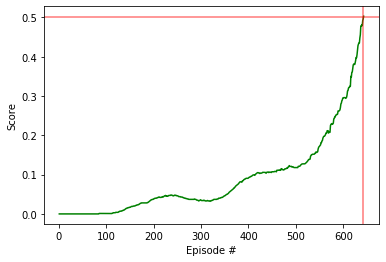

0 Solved at Episode:  642


In [53]:
import matplotlib.pyplot as plt

fig = plt.figure()
scores_average = []
pass_episode = 0

average_over = 100
average_buffer = deque(maxlen=100)
running_score_history = []

for i in range(len(combined)):
    average_buffer.append(combined[i])
    scores_average.append(np.mean(average_buffer));
    if(scores_average[i] >= 0.5 and pass_episode == 0):
        pass_episode = i;
    
ax = fig.add_subplot(111)
#plt.plot(np.arange(1, len(scores_average0)+1), scores_average0, 'b')
#plt.plot(np.arange(1, len(scores_average1)+1), scores_average1, 'g')
plt.plot(np.arange(1, len(scores_average)+1), scores_average, 'g')

plt.axhline(0.5,0,150, color='r', linewidth=2.0 ,alpha=0.4 )
plt.axvline(pass_episode,0,40, color='r', linewidth=2.0, alpha=0.4 )
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
print("0 Solved at Episode: ", pass_episode);